In [ ]:
import pandas as pd

url = "https://gksmyth.github.io/ozdasl/oz/stroke.txt"
df = pd.read_csv(url, sep='\t')

print(df)

# UE dist

In [ ]:
import pymc as pm
import pandas as pd
import numpy as np

df['Sex_code'] = df['Sex'].replace({'M': 0, 'F': 1})
df['Side_code'] = df['Side'].replace({'L': 0, 'R': 1})

long_df = pd.wide_to_long(df, stubnames=['UE', 'HW', 'LE', 'Bal', 'Bart'], i='Subject', j='Week').reset_index()
long_df


,Subject,Week,Side,Sex_code,Lapse,Age,Group,Sex,Side_code,UE,HW,LE,Bal,Bart
0,I,1,R,0,11.0,74,E,M,1,15,4,20,8,45
1,II,1,L,0,2.0,61,E,M,0,3,0,2,2,20
2,III,1,R,0,6.0,49,E,M,1,2,0,4,4,50
3,IV,1,L,0,1.0,68,E,M,0,14,5,7,1,25
4,V,1,R,0,33.0,55,E,M,1,22,0,20,10,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,D,8,R,0,1.0,69,G,M,1,28,16,21,11,100
188,E,8,R,0,7.0,59,G,M,1,36,24,25,11,100
189,F,8,L,1,2.0,76,G,F,0,8,0,13,5,40
190,G,8,L,1,2.0,75,G,F,0,6,0,9,4,40


In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values

ue_scores = long_df['UE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_UE:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code + pm.Normal('Age', mu=0, sigma=10, shape=n_subjects)[subject_idx] * age

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age_day * age * week + beta_age_lapse * age * lapse + group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=ue_scores)

    # 后验采样
    UE_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(UE_trace)
UE_posterior_summary = az.summary(UE_trace, round_to=2)
print(UE_posterior_summary)

KeyError: 0

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_effect[0]   0.08   9.97  -20.13    16.83       0.18     0.21   3201.43   
group_effect[1]   0.18  10.00  -19.97    18.16       0.19     0.25   2752.69   
group_effect[2]   0.11  10.09  -18.37    19.22       0.15     0.25   4303.53   
mu_alpha          0.65   9.26  -16.65    18.36       0.58     0.41    264.11   
alpha_subject[0]  0.94  13.48  -24.50    25.60       0.59     0.42    526.33   
...                ...    ...     ...      ...        ...      ...       ...   
Age[20]           0.21   8.35  -16.48    14.98       0.58     0.41    210.15   
Age[21]           0.44   0.27   -0.06     0.98       0.01     0.01    471.15   
Age[22]           0.29   1.29   -2.10     2.72       0.09     0.06    200.31   
Age[23]           0.44   0.33   -0.17     1.09       0.01     0.01    502.70   
sigma             8.80   0.49    7.94     9.73       0.01     0.01   2938.32   

                  ess_tail  r_hat  
gro

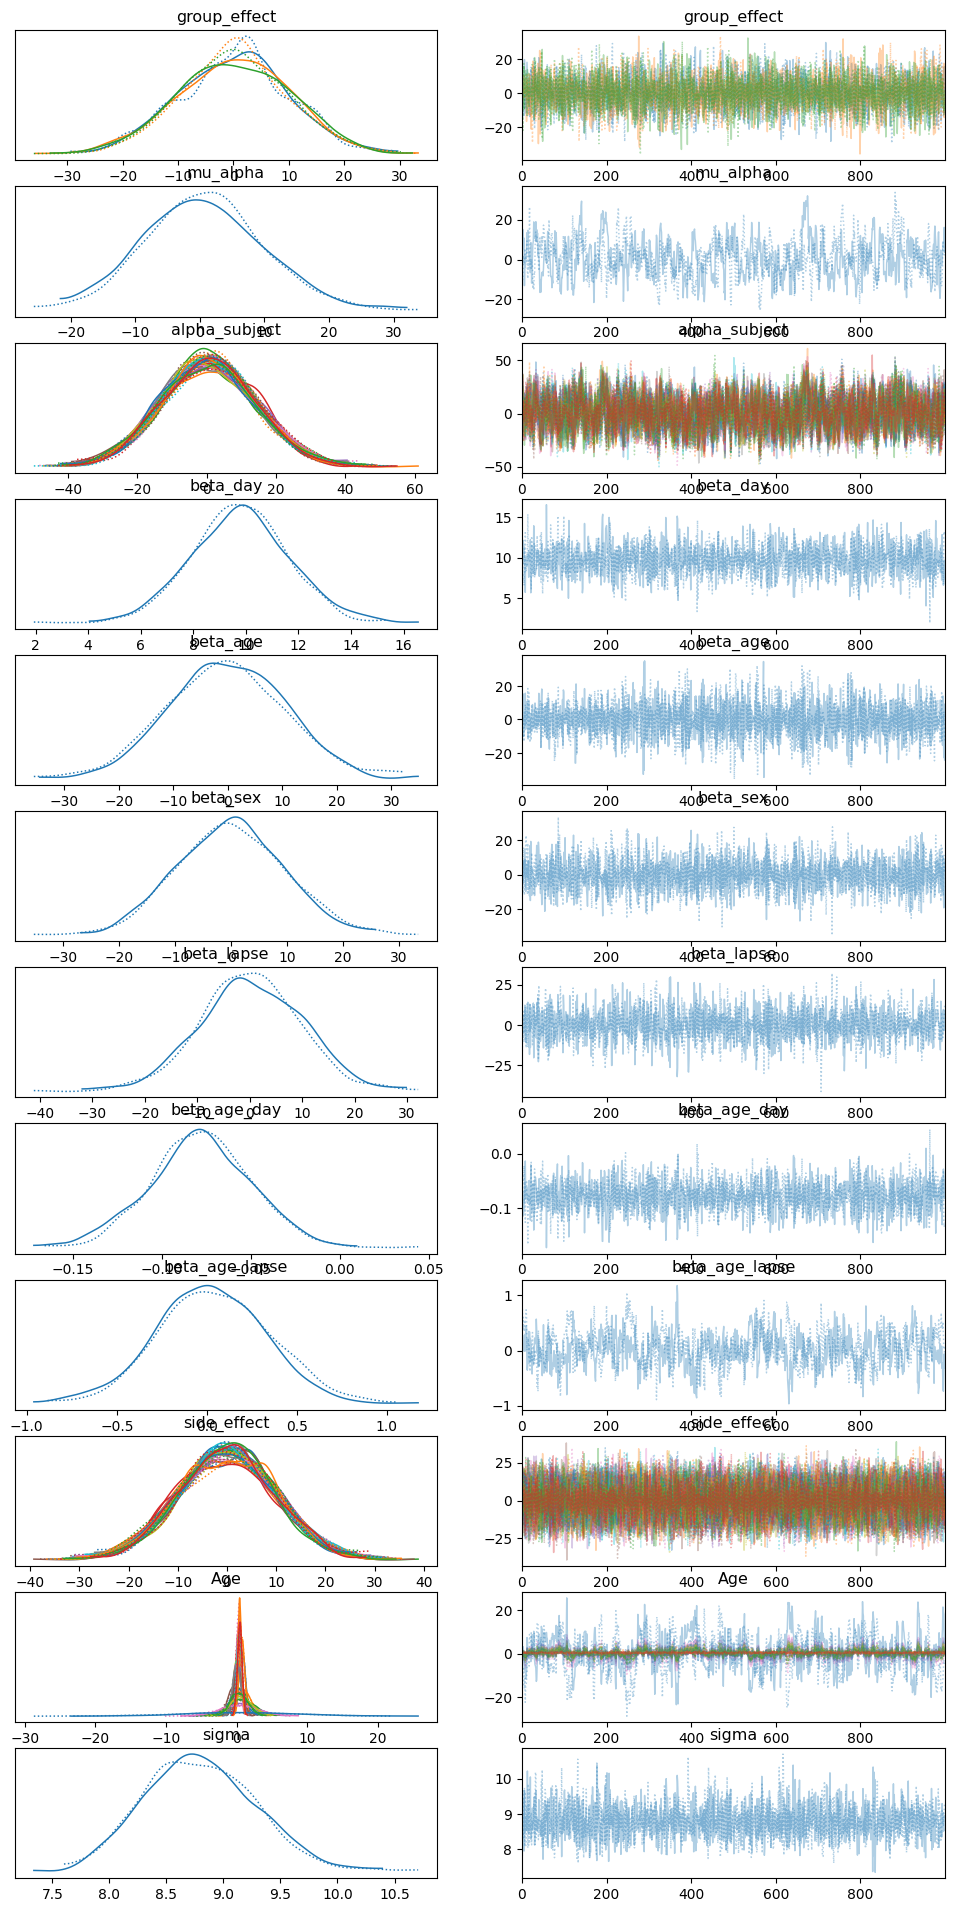

In [ ]:
# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


# age = long_df['Age'].values
# week = long_df['Week'].values
# side_code = long_df['Side_code'].values
# sex = long_df['Sex_code'].values
# lapse = long_df['Lapse'].values
# # change
ue_scores = long_df['Bart'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
# group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

with pm.Model() as hierarchical_model_Bart:

    # 定义共享数据容器
    subject_idx = pm.MutableData('subject_idx', long_df['Subject'].astype('category').cat.codes.values)
    age = pm.MutableData('age', long_df['Age'].values)
    week = pm.MutableData('week', long_df['Week'].values)
    sex = pm.MutableData('sex', long_df['Sex_code'].values)
    side_code = pm.MutableData('side_code', long_df['Side_code'].values)
    lapse = pm.MutableData('lapse', long_df['Lapse'].values)

    group_effect = pm.Normal('group_effect', mu=0, sigma=10, shape=n_groups)
    #group_idx = pm.Data('group_idx', long_df['Group_code'].values)
    group_idx = pm.MutableData('group_idx', long_df['Group_code'].values)
    # 全局截距的先验
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)

    # 每个病人截距的随机效应
    alpha_subject = pm.Normal('alpha_subject', mu=mu_alpha, sigma=10, shape=n_subjects)

    # 固定效应的斜率先验
    beta_day = pm.Normal('beta_day', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_lapse = pm.Normal('beta_lapse', mu=0, sigma=10)

    beta_age_day = pm.Normal('beta_age_day', mu=0, sigma=10)
    beta_age_lapse = pm.Normal('beta_age_lapse', mu=0, sigma=10)

    # 对每个病人截距的随机效应进行调整
    alpha_adjusted = alpha_subject[subject_idx] + pm.Normal('side_effect', mu=0, sigma=10, shape=n_subjects)[subject_idx] * side_code + pm.Normal('Age', mu=0, sigma=10, shape=n_subjects)[subject_idx] * age

    # 模型的期望值
    mu = alpha_adjusted + beta_day * week +  beta_sex * sex + beta_lapse * lapse + beta_age_day * age * week + beta_age_lapse * age * lapse +group_effect[group_idx]

    # 观测的似然
    sigma = pm.HalfCauchy('sigma', beta=2)

    # change
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=ue_scores)

    # 后验采样
    Bart_trace = pm.sample(1000, return_inferencedata=True)

import arviz as az

# 使用转换后的InferenceData进行可视化和分析
az.plot_trace(Bart_trace)
Bart_posterior_summary = az.summary(Bart_trace, round_to=2)
print(Bart_posterior_summary)

In [ ]:
# 假设 long_df 是你已经转换为长格式的原始数据框
# 获取第八周的数据来创建第九周的数据框架
#需要改成替换8
week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['UE'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
ue_scores = long_df['UE'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

In [ ]:
week_9_data['Group_code'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

# Predict weeek 9

In [ ]:
# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(UE.trace)



NameError: name 'UE' is not defined

In [ ]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [ ]:
# 假设 long_df 是你已经转换为长格式的原始数据框
# 获取第八周的数据来创建第九周的数据框架
#需要改成替换8
week_8_data = long_df.copy()
week_9_data = week_8_data.copy()
week_9_data['Week'] = 9  # 将周数设置为9
week_9_data['Bart'] = np.nan  # UE分数设置为缺失，因为我们想预测它
week_9_data


# 为模型中使用的变量定义一些索引变量
subject_idx = long_df['Subject'].astype('category').cat.codes.values


age = long_df['Age'].values
week = long_df['Week'].values
side_code = long_df['Side_code'].values
sex = long_df['Sex_code'].values
lapse = long_df['Lapse'].values
# change
Bart_scores = long_df['Bart'].values

n_subjects = len(long_df['Subject'].unique())

long_df['Group_code'] = long_df['Group'].astype('category').cat.codes.values
group_idx = long_df['Group_code'].values
n_groups = long_df['Group'].nunique()

# 更新模型数据
with hierarchical_model_UE:
    pm.set_data({'group_idx': week_9_data['Group_code'].values,
        'subject_idx': week_9_data['Subject'].astype('category').cat.codes.values,
        'week': week_9_data['Week'].values,
        'age': week_9_data['Age'].values,
        'sex': week_9_data['Sex_code'].values,
        'side_code': week_9_data['Side_code'].values,
        'lapse': week_9_data['Lapse'].values})

    # 进行后验预测
    posterior_predictive = pm.sample_posterior_predictive(Bart_trace)

# 获取第九周UE分数的预测值
predicted_ue_scores = posterior_predictive.posterior_predictive['likelihood'].values
predicted_ue_scores
predicted_ue_scores_week_9 = predicted_ue_scores.mean(axis=0)[-len(week_9_data):]
predicted_ue_scores_week_9


import pandas as pd
import numpy as np

# Flatten the last dimension if necessary and then take the mean and percentiles
predicted_ue_scores_week_9 = predicted_ue_scores.reshape(-1, len(week_9_data))  # Reshape to combine chains and samples

# Calculate mean and percentiles for the predicted UE scores
mean_predicted_scores = np.mean(predicted_ue_scores_week_9, axis=0)
ci_lower = np.percentile(predicted_ue_scores_week_9, 2.5, axis=0)
ci_upper = np.percentile(predicted_ue_scores_week_9, 97.5, axis=0)

# Now we can safely assign the values to the DataFrame columns
week_9_data['Predicted_Bart_Mean'] = mean_predicted_scores
week_9_data['Predicted_Bart_Lower'] = ci_lower
week_9_data['Predicted_Bart_Upper'] = ci_upper

# Create the final dataset with selected columns
predicted_scores_dataset = week_9_data[['Subject', 'Predicted_Bart_Mean', 'Predicted_Bart_Lower', 'Predicted_Bart_Upper']]
predicted_scores_dataset

# Select and display rows where the 'Subject' column is 'IV'
predicted_scores_for_subject_IV = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV']
predicted_scores_for_subject_IV

# Calculate the mean prediction and 95% confidence interval for Subject IV
predicted_bart_mean_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Mean'].mean()
predicted_bart_lower_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Lower'].mean()
predicted_bart_upper_iv = predicted_scores_dataset.loc[predicted_scores_dataset['Subject'] == 'IV', 'Predicted_Bart_Upper'].mean()

# Create a summary DataFrame for Subject IV
summary_iv = pd.DataFrame({
    'Subject': 'IV',
    'Predicted_Bart_Mean': [predicted_bart_mean_iv],
    'Predicted_Bart_Lower': [predicted_bart_lower_iv],
    'Predicted_Bart_Upper': [predicted_bart_upper_iv]
})

summary_iv


ValueError: Expected a 1D array, got an array with shape (24, 192)

In [ ]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace)

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

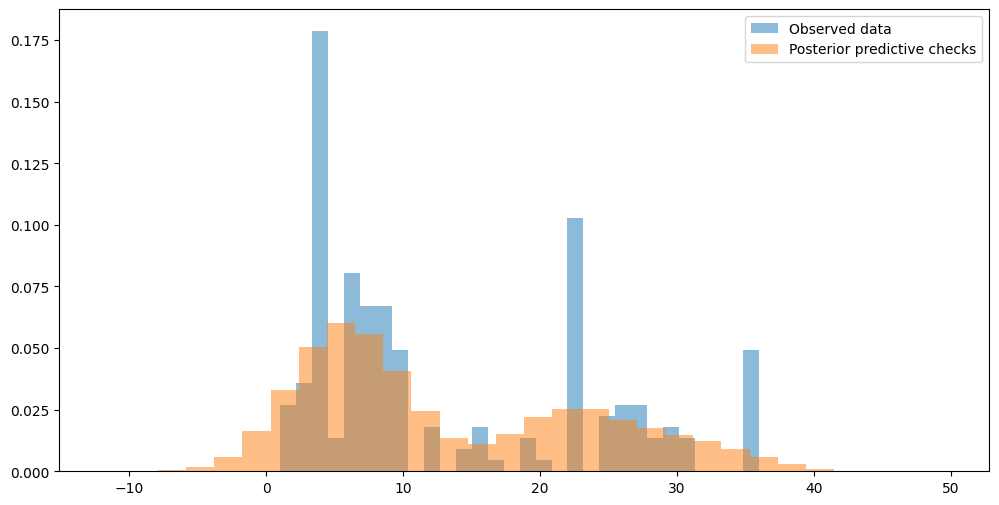

In [ ]:
import matplotlib.pyplot as plt
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(UE_trace)
    ppc_data0 = ppc.posterior_predictive
    ppc_data = ppc_data0['likelihood'].values


_, ax = plt.subplots(figsize=(12, 6))
ax.hist(ue_scores, bins=30, density=True, alpha=0.5, label='Observed data')
ax.hist(ppc_data.flatten(), bins=30, density=True, alpha=0.5, label='Posterior predictive checks')
ax.legend()
plt.show()

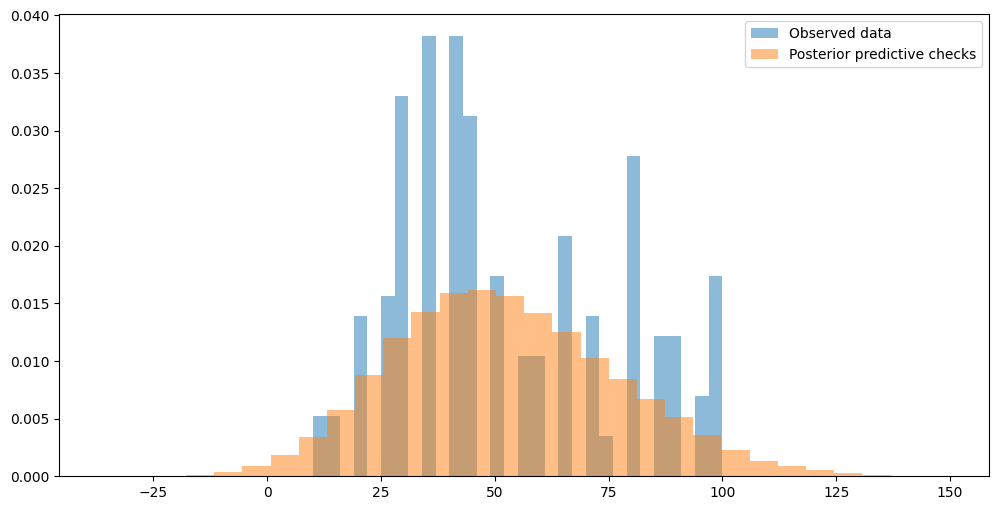

In [ ]:
import matplotlib.pyplot as plt
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(Bart_trace)
    ppc_data0 = ppc.posterior_predictive
    ppc_data = ppc_data0['likelihood'].values


_, ax = plt.subplots(figsize=(12, 6))
ax.hist(ue_scores, bins=30, density=True, alpha=0.5, label='Observed data')
ax.hist(ppc_data.flatten(), bins=30, density=True, alpha=0.5, label='Posterior predictive checks')
ax.legend()
plt.show()


In [ ]:
import numpy as np
import pymc as pm

# 定义治疗组映射
group_code_map = {'E': 0, 'F': 1, 'G': 2}
new_group = 'G'
new_group_code = group_code_map[new_group]

# 选出F组的受试者的索引
f_group_index = long_df[long_df['Group'] == 'E'].index
#f_group_index
# 安全地替换成新的治疗组
long_df.loc[f_group_index, 'Group_code'] = new_group_code


In [ ]:
with hierarchical_model:
    post_pred = pm.sample_posterior_predictive(trace)

    # 打印后验预测中的所有变量名称
    #print(posterior_predictive.keys())

    # 获取后验预测
    posterior_predictive = post_pred.posterior_predictive
    print(posterior_predictive.keys())
    # 使用正确的键访问后验预测数据
    ue_scores_pred = posterior_predictive['likelihood'].values
    #ue_scores_pred

    # 现在可以计算均值和置信区间
    mean_scores_g = np.mean(ue_scores_pred, axis=0)
    lower_g = np.percentile(ue_scores_pred, 2.5, axis=0)
    upper_g = np.percentile(ue_scores_pred, 97.5, axis=0)

    # 输出结果
    print("预测G组效果:", mean_scores_g, lower_g, upper_g)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 20.28 ... 11.4
Attributes:
    created_at:                 2024-03-30T11:07:10.208911
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)
预测G组效果: [[21.32810967  1.77085588  2.31654088 ... 12.46010191  8.52561631
  10.38340339]
 [20.96085331 -0.65641058 -1.0471753  ... 10.0373985   6.13196584
   9.53252402]
 [22.95579595  2.04082142  4.83047972 ... 10.74914455  8.26668166
  10.51739069]
 ...
 [20.7787895   8.00641188  5.15625371 ... 10.13865661  7.80052348
  10.27948288]
 [19.12116531  3.47226541  2.60164527 ...  4.69477509  4.05918219
  10.594

In [ ]:
import pandas as pd
import numpy as np

# 假设long_df中的'Group_code'列现在代表的是每个受试者在F组治疗下的组别编码

# 创建一个空的DataFrame来保存数据
results_df = pd.DataFrame()

# 从原始数据集中添加受试者ID和他们原始的治疗组信息
results_df['Subject'] = df['Subject']
results_df['Original_Group'] = df['Group']

# 假设'Current_Group_code'表示当前治疗组的编码，这里我们加入了F组
results_df['Current_Group'] = 'F'

# 这里加入原始的UE分数作为参考
for i in range(1, 9):
    results_df[f'Original_UE{i}'] = df[f'UE{i}']

for i in range(1, 9):

    # Here we use i-1 to index the second dimension, assuming it represents the time points
    results_df[f'Predicted_UE_Mean_{i}'] = mean_scores_g[:, i-1].mean(axis=0)  # Mean across chains
    results_df[f'Predicted_UE_Lower_{i}'] = np.percentile(mean_scores_g[:, i-1], 2.5, axis=0)  # Lower bound
    results_df[f'Predicted_UE_Upper_{i}'] = np.percentile(mean_scores_g[:, i-1], 97.5, axis=0)  # Upper bound


# 最后打印结果查看
(results_df.head())

# 如果需要将DataFrame保存到CSV文件
# results_df.to_csv('/mnt/data/stroke_treatment_predictions.csv', index=False)


,Subject,Original_Group,Current_Group,Original_UE1,Original_UE2,Original_UE3,Original_UE4,Original_UE5,Original_UE6,Original_UE7,...,Predicted_UE_Upper_5,Predicted_UE_Mean_6,Predicted_UE_Lower_6,Predicted_UE_Upper_6,Predicted_UE_Mean_7,Predicted_UE_Lower_7,Predicted_UE_Upper_7,Predicted_UE_Mean_8,Predicted_UE_Lower_8,Predicted_UE_Upper_8
0,I,E,F,15,23,23,26,26,26,28,...,23.608582,17.880997,13.31402,22.167104,4.54855,-0.025705,9.061864,2.219982,-2.321555,6.585613
1,II,E,F,3,3,3,5,6,6,6,...,23.608582,17.880997,13.31402,22.167104,4.54855,-0.025705,9.061864,2.219982,-2.321555,6.585613
2,III,E,F,2,2,4,7,7,10,10,...,23.608582,17.880997,13.31402,22.167104,4.54855,-0.025705,9.061864,2.219982,-2.321555,6.585613
3,IV,E,F,14,25,25,31,31,36,36,...,23.608582,17.880997,13.31402,22.167104,4.54855,-0.025705,9.061864,2.219982,-2.321555,6.585613
4,V,E,F,22,22,22,22,22,22,22,...,23.608582,17.880997,13.31402,22.167104,4.54855,-0.025705,9.061864,2.219982,-2.321555,6.585613


In [ ]:
def predict_group_effect(subjects_df, new_group, model, trace):

    # 定义治疗组映射
    group_code_map = {'E': 0, 'F': 1, 'G': 2}
    new_group_code = group_code_map[new_group]

    # 选出F组的受试者的索引
    # change
    f_group_index = long_df[long_df['Group'] == 'E'].index
    #f_group_index
    # 安全地替换成新的治疗组
    long_df.loc[f_group_index, 'Group_code'] = new_group_code


    with model:
        post_pred = pm.sample_posterior_predictive(trace)

        # 获取后验预测
        posterior_predictive = post_pred.posterior_predictive
        print(posterior_predictive.keys())
        # 使用正确的键访问后验预测数据
        ue_scores_pred = posterior_predictive['likelihood'].values
        #ue_scores_pred

        # 现在可以计算均值和置信区间
        mean_scores = np.mean(ue_scores_pred, axis=0)
        lower_bounds = np.percentile(ue_scores_pred, 2.5, axis=0)
        upper_bounds = np.percentile(ue_scores_pred, 97.5, axis=0)

    return mean_scores, lower_bounds, upper_bounds

# Now you can call this function after running your model and obtaining the trace
# mean_scores_g, lower_g, upper_g = predict_group_effect(long_df, 'G', hierarchical_model, trace)


In [ ]:
predict_group_effect(long_df, 'G', hierarchical_model, trace)
predict_group_effect(long_df, 'F', hierarchical_model, trace)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 22.33 ... 6.738
Attributes:
    created_at:                 2024-03-31T00:51:09.576692
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 26.26 ... 9.584
Attributes:
    created_at:                 2024-03-31T00:51:10.202081
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


(array([[23.32321366,  1.44761075,  6.11979764, ...,  6.10758989,
          9.20002682, 11.662185  ],
        [23.6816226 ,  6.73585144,  1.8828327 , ..., 10.68877609,
          8.82547925,  7.98500246],
        [20.40013315,  6.43489646,  2.29196593, ...,  5.13807609,
          6.75572208,  6.72111122],
        ...,
        [20.701022  ,  4.06792239,  0.78687838, ...,  8.82263432,
         10.77752652,  4.61727555],
        [21.42918681,  0.73174053,  2.7808768 , ..., 10.87643727,
          6.0425436 ,  8.45554696],
        [26.46390337,  1.99810085,  2.3743846 , ...,  8.72209378,
          7.23992855, 10.04407967]]),
 array([[20.53227348, -2.34886795,  4.43746241, ...,  5.11237092,
          7.81873863,  8.85858859],
        [21.76729342,  5.97093881,  1.84183727, ...,  7.39859641,
          7.55099154,  7.65138487],
        [19.73783821,  4.43587902,  1.71824354, ...,  4.31281654,
          6.03242574,  4.95809716],
        ...,
        [17.73513526,  3.37420216, -2.26717896, ...,  

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 14.68 ... 11.64
Attributes:
    created_at:                 2024-03-31T00:59:11.779279
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 23.95 ... 9.892
Attributes:
    created_at:                 2024-03-31T00:59:13.353082
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 21.12 ... 12.3
Attributes:
    created_at:                 2024-03-31T00:59:14.459551
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


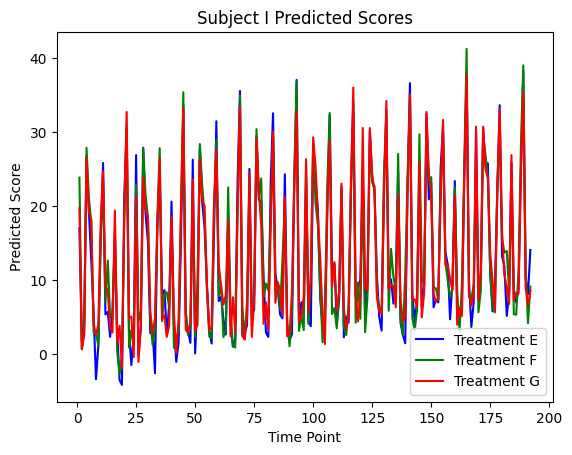

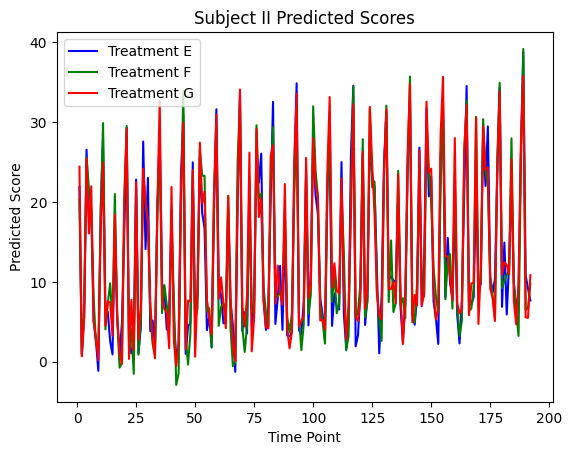

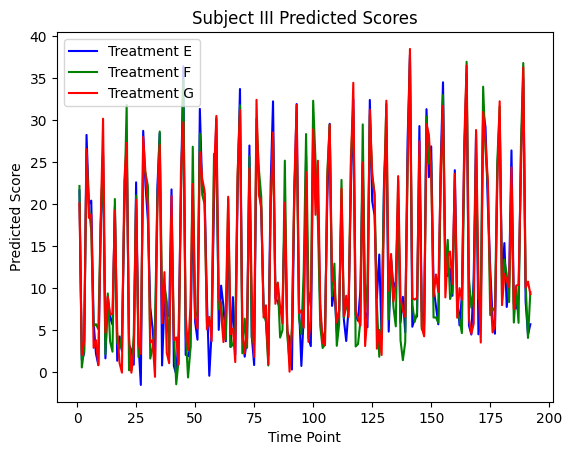

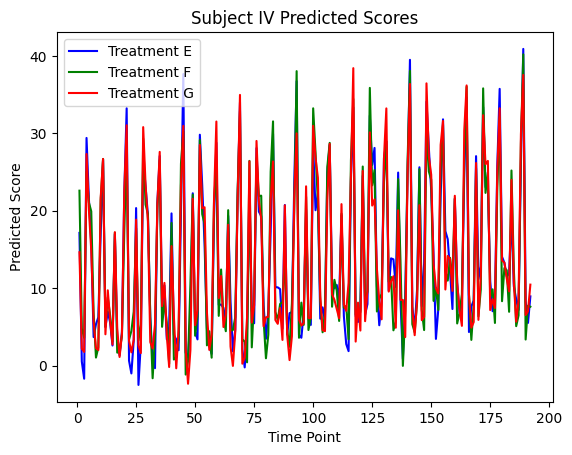

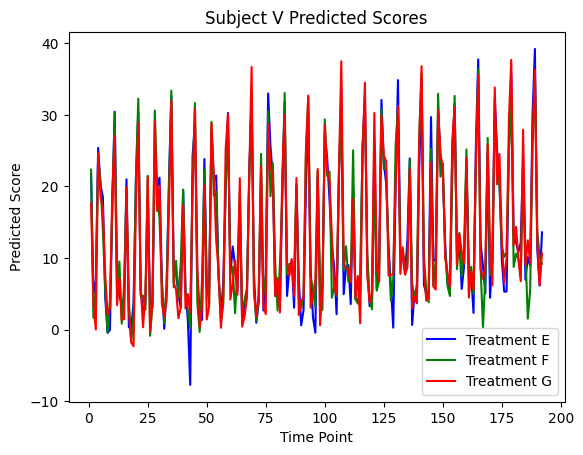

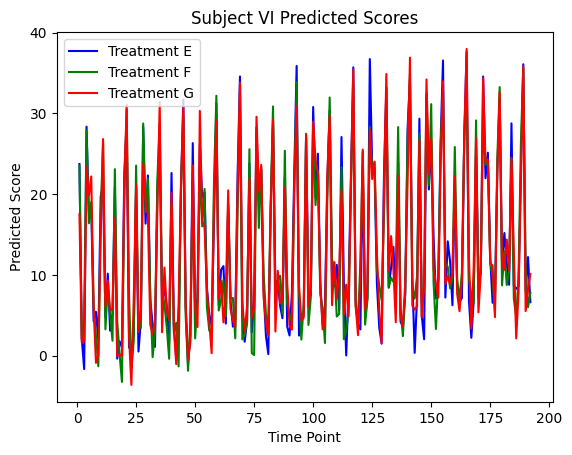

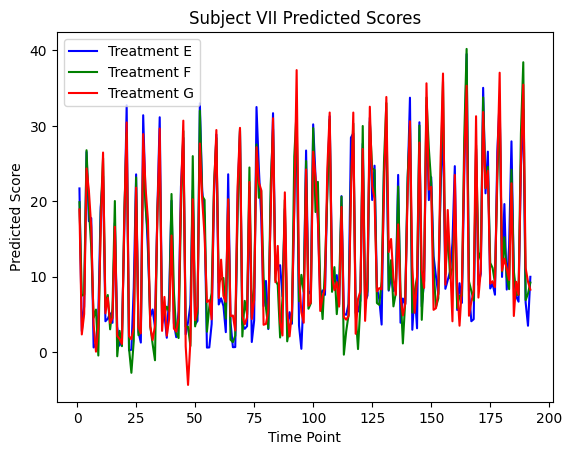

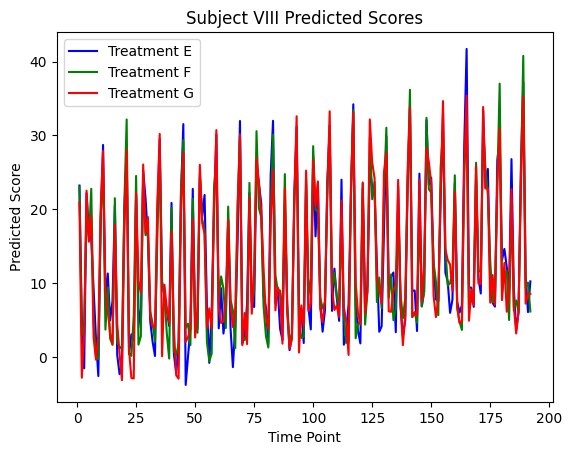

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(subjects_df, mean_scores_dict):
    subjects = subjects_df[subjects_df['Group'] == 'E']['Subject'].unique()

    for subject in subjects:
        plt.figure()
        subject_index = np.where(subjects_df['Subject'] == subject)[0][0]  # 获取受试者的索引
        for treatment, color in zip(['E', 'F', 'G'], ['blue', 'green', 'red']):
            mean_scores = mean_scores_dict[treatment][subject_index, :]

            time_points = np.arange(1, mean_scores.shape[0] + 1)

            plt.plot(time_points, mean_scores, label=f'Treatment {treatment}', color=color)

        plt.title(f'Subject {subject} Predicted Scores')
        plt.xlabel('Time Point')
        plt.ylabel('Predicted Score')
        plt.legend()
        plt.show()

mean_scores_E, _, _ = predict_group_effect(long_df, 'E', hierarchical_model, trace)
mean_scores_F, _, _ = predict_group_effect(long_df, 'F', hierarchical_model, trace)
mean_scores_G, _, _ = predict_group_effect(long_df, 'G', hierarchical_model, trace)

mean_scores_dict = {
    'E': mean_scores_E,
    'F': mean_scores_F,
    'G': mean_scores_G
}

visualize_predictions(long_df, mean_scores_dict)


In [ ]:
# 使用函数为F组受试者预测G和E组的效果
mean_scores_g, lower_g, upper_g = predict_group_effect(long_df, 'G', hierarchical_model, trace)
mean_scores_e, lower_e, upper_e = predict_group_effect(long_df, 'E', hierarchical_model, trace)
mean_scores_f, lower_f, upper_f = predict_group_effect(long_df, 'F', hierarchical_model, trace)

# 输出或保存结果
# print("预测G组效果:", mean_scores_g, lower_g, upper_g)
# print("预测F组效果:", mean_scores_e, lower_e, upper_e)

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 25.38 ... 12.25
Attributes:
    created_at:                 2024-03-31T01:09:36.071148
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 21.63 ... 8.136
Attributes:
    created_at:                 2024-03-31T01:09:36.584339
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 24.48 ... 11.7
Attributes:
    created_at:                 2024-03-31T01:09:37.067922
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


ValueError: could not broadcast input array from shape (3000,) into shape (3,)

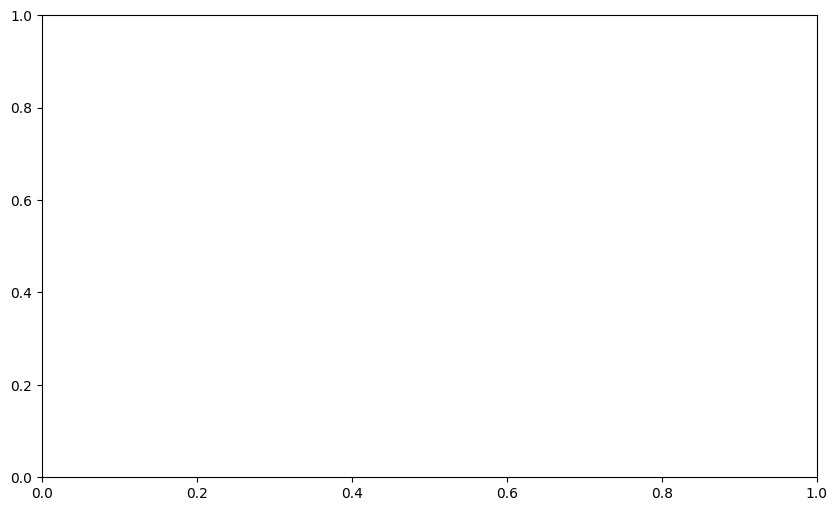

In [ ]:
import matplotlib.pyplot as plt

def create_forest_plot(mean_scores, lower_bounds, upper_bounds, subjects_df, treatment_labels=['E', 'F', 'G']):
    # Determine the number of subjects and treatments
    n_subjects = mean_scores.shape[1]  # Assumes subjects are along the second dimension
    n_treatments = len(treatment_labels)

    # Create the forest plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Assuming the mean_scores, lower_bounds, and upper_bounds are 2D arrays with shape (treatments, subjects)
    for i, subject in enumerate(subjects_df['Subject'].unique()):
        # Get the y position for this subject's treatments
        y_pos = range(i * n_treatments, i * n_treatments + n_treatments)

        # Draw the mean score lines for this subject
        ax.hlines(y_pos, lower_bounds[:, i], upper_bounds[:, i], color='black', zorder=1)

        # Draw points for the mean scores
        ax.scatter(mean_scores[:, i], y_pos, color='blue', zorder=2)

        # Label the y-axis with the subject IDs
        if i == 0:
            # Initialize labels list with the treatment labels for the first subject
            labels = [f'Subject {subject} - Treatment {treat}' for treat in treatment_labels]
        else:
            # For subsequent subjects, just append the subject ID
            labels += [f'Subject {subject}']

    # Set the y-axis labels
    ax.set_yticks(range(0, n_subjects * n_treatments))
    ax.set_yticklabels(labels)

    # Set the labels and title
    ax.set_xlabel('Score')
    ax.set_title('Predicted Scores with 95% CI for Each Treatment')

    # Show grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()



# Concatenate the arrays for means and CIs along the first axis to form arrays of shape (treatments, subjects)
mean_scores_all = np.concatenate([mean_scores_e, mean_scores_f, mean_scores_g], axis=0)
lower_all = np.concatenate([lower_e, lower_f, lower_g], axis=0)
upper_all = np.concatenate([upper_e, upper_f, upper_g], axis=0)

# Now call the function to create the plot
create_forest_plot(mean_scores_all, lower_all, upper_all, long_df)


In [ ]:

def compile_results(subjects_df, original_group, predicted_means, predicted_lowers, predicted_uppers):
    results_df = pd.DataFrame()
    results_df['Subject'] = subjects_df['Subject']
    results_df['Original_Group'] = subjects_df['Group']
    results_df['Current_Group'] = original_group

    # Adding original UE scores
    for i in range(1, 9):
        results_df[f'Original_UE{i}'] = subjects_df[f'UE{i}']

    # Adding predicted means and confidence intervals for UE scores
    for i in range(1, 9):
        results_df[f'Predicted_UE_Mean_{i}'] = mean_scores_g[:, i-1].mean(axis=0)  # Mean across chains
        results_df[f'Predicted_UE_Lower_{i}'] = np.percentile(mean_scores_g[:, i-1], 2.5, axis=0)  # Lower bound
        results_df[f'Predicted_UE_Upper_{i}'] = np.percentile(mean_scores_g[:, i-1], 97.5, axis=0)

    return results_df





In [ ]:
mean_scores_g, lower_g, upper_g = predict_group_effect(long_df, 'G', hierarchical_model, trace)

results_df_G = compile_results(df[df['Group'] == 'F'], 'G', mean_scores_g, lower_g, upper_g)

results_df_G

KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 1000, likelihood_dim_2: 192)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 187 188 189 190 191
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) float64 22.38 ... 9.946
Attributes:
    created_at:                 2024-03-31T00:51:57.251036
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4)


,Subject,Original_Group,Current_Group,Original_UE1,Original_UE2,Original_UE3,Original_UE4,Original_UE5,Original_UE6,Original_UE7,...,Predicted_UE_Upper_5,Predicted_UE_Mean_6,Predicted_UE_Lower_6,Predicted_UE_Upper_6,Predicted_UE_Mean_7,Predicted_UE_Lower_7,Predicted_UE_Upper_7,Predicted_UE_Mean_8,Predicted_UE_Lower_8,Predicted_UE_Upper_8
8,1,F,G,4,4,4,4,4,4,4,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
9,2,F,G,17,22,22,22,22,22,22,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
10,3,F,G,36,36,27,26,30,30,30,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
11,4,F,G,2,3,3,9,12,12,12,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
12,5,F,G,10,10,10,10,10,10,10,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
13,6,F,G,7,7,7,7,7,7,7,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
14,7,F,G,4,4,6,8,8,8,8,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
15,8,F,G,19,19,19,22,22,22,22,...,23.117611,17.814239,13.28142,22.075602,4.560768,0.206726,8.971531,2.303938,-2.057676,6.733134
